In [1]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation



In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
TRAIN_DATASET_PATH = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [4]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File is already renamed!


In [5]:
# load .nii file as a numpy array
test_image_flair = nib.load("BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [6]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [7]:
scaler = MinMaxScaler()

In [8]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [9]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [10]:
# rescaling t1
test_image_t1 = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


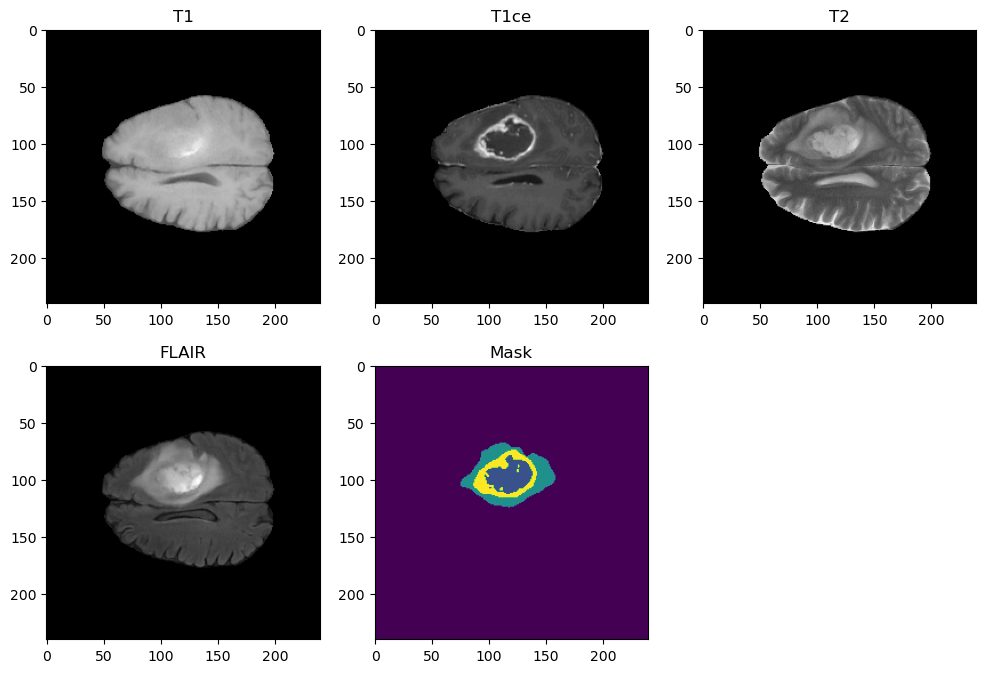

In [11]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

**Detailed Description of Each Modality:**

-  Native (T1): This modality reveals the structure and composition of various tissue types in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
-  Post-contrast T1-weighted (T1ce, also known as T1Gd): Similar to T1 images, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
-  T2-weighted (T2): This modality highlights the fluid content within brain tissues.
-  T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery): This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, T1ce, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the T2-FLAIR modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.

 These scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image provides a digital representation of a 3D object, such as a brain in our case. The NIfTI format is widely used in neuroimaging because it efficiently handles complex, multi-dimensional data and includes metadata for spatial orientation and scaling.

In [12]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation.

These 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body and, therefore, the human brain.

Here is a quick presentation of these 3 planes:

-  Axial (Transverse) Plane: This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
-  Coronal (Frontal) Plane: This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
-  Sagittal (Lateral) Plane: This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Slice number: 95


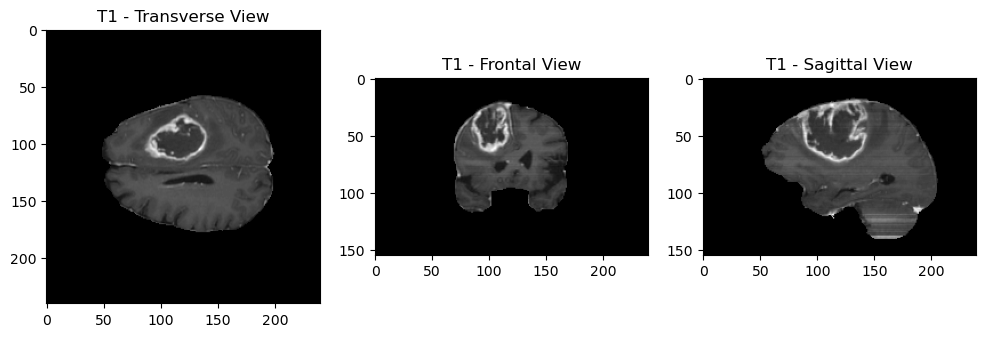

In [13]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

By examining all the slices, we can identify the slice that best represents the region of interest, such as the area where a tumor is located.

To visualize this, we will display all the slices along one dimension:

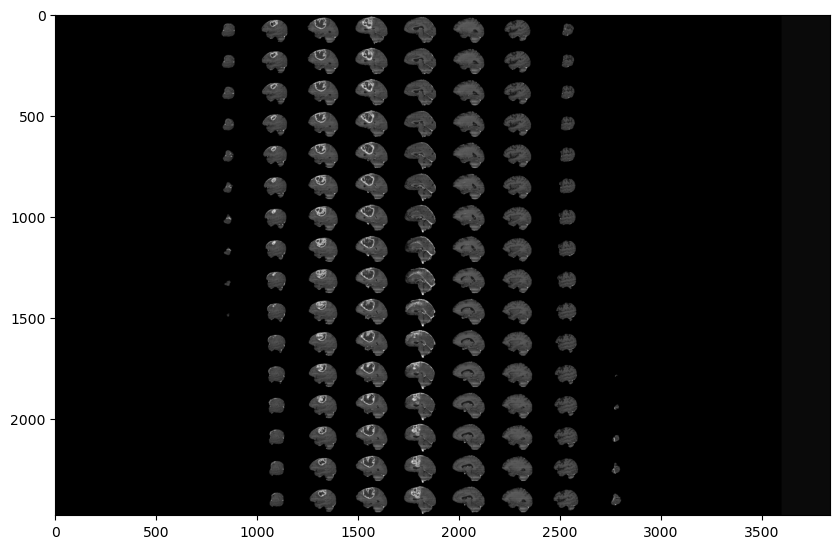

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

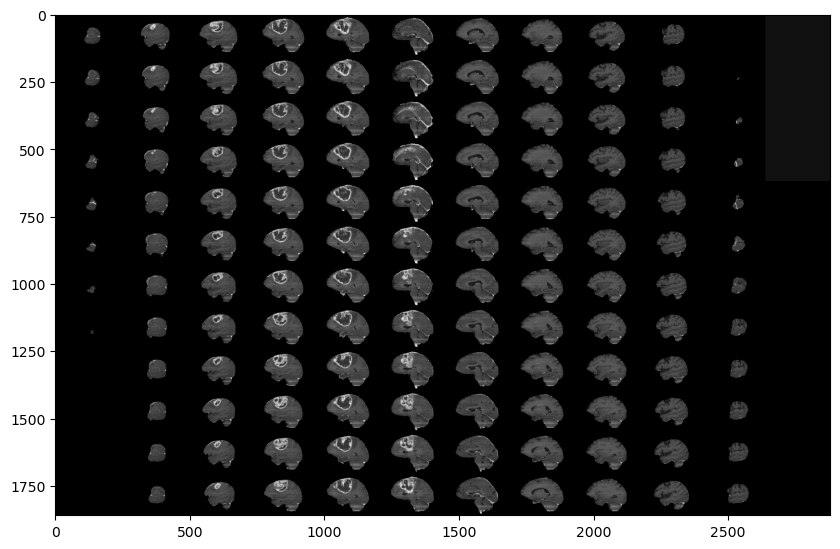

In [15]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

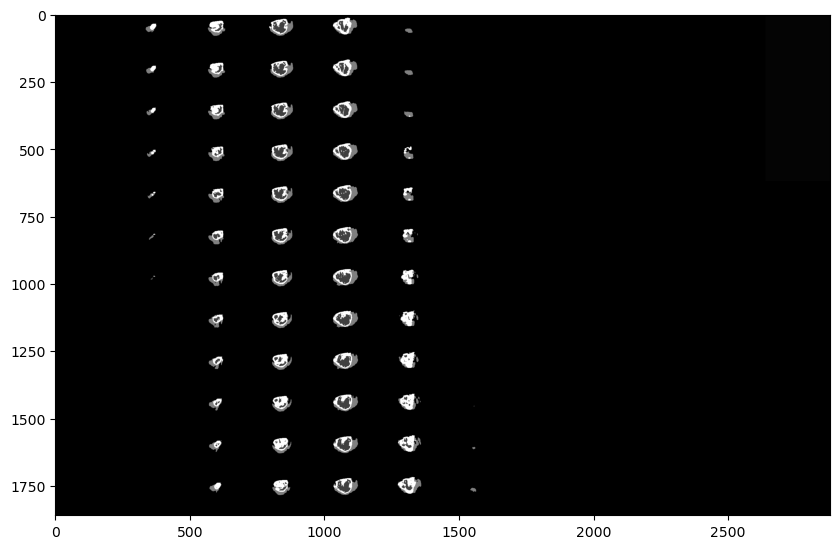

In [16]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

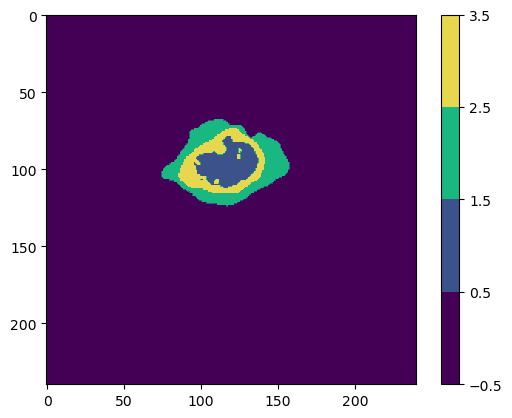

In [17]:
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

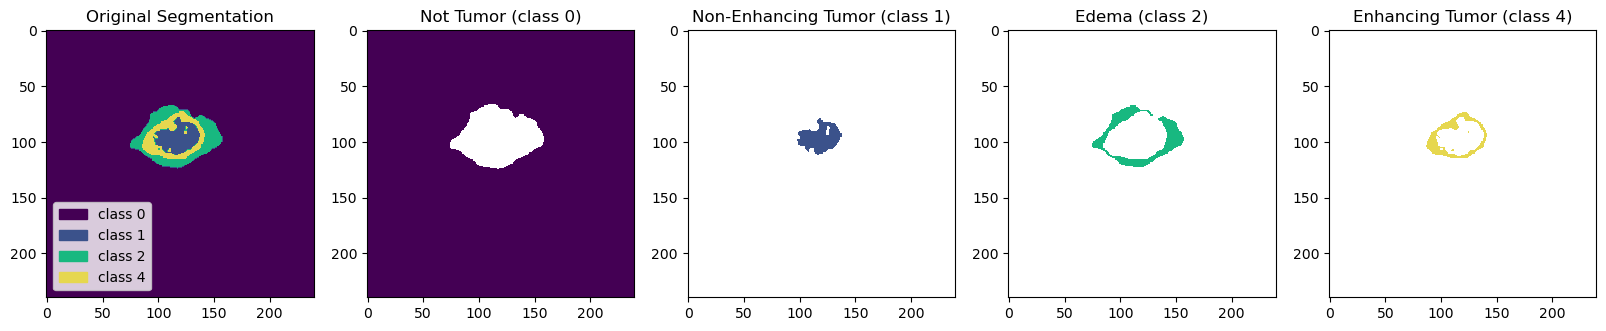

In [18]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

**Split the Dataset**

In [19]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [20]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


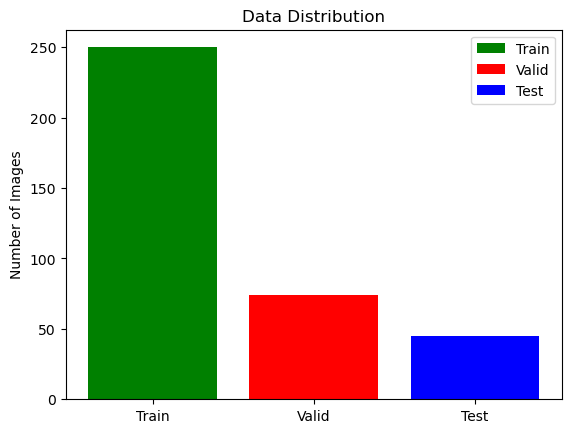

In [21]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

**Prepare Model For Training** 

In [22]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [23]:
import numpy as np
import os
import cv2
import nibabel as nib
import tensorflow as tf
import keras
from scipy.ndimage import zoom

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(128, 128, 128), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim  # (Depth, Height, Width)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates 3D data containing batch_size samples'
        X = np.zeros((self.batch_size, *self.dim, self.n_channels))  # (Batch, Depth, Height, Width, Channels)
        y = np.zeros((self.batch_size, *self.dim))  # (Batch, Depth, Height, Width)

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            # Load NIfTI images
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            # Resize entire 3D volumes to (128,128,128)
            X[c, :, :, :, 0] = resize_3d(flair, (128, 128, 128))
            X[c, :, :, :, 1] = resize_3d(t1ce, (128, 128, 128))
            y[c] = resize_3d(seg, (128, 128, 128))

        # Convert labels to categorical (One-hot encoding for 4 classes)
        y[y == 4] = 3  # Adjust labels
        Y = tf.one_hot(y, 4)

        return X / np.max(X), Y  # Normalize X

# Initialize the 3D Data Generator
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


**The DataGenerator Class** is responsible for efficiently loading and preprocessing the MRI data (such as FLAIR, T1ce images) and their corresponding segmentation masks in batches, making it suitable for deep learning tasks like brain tumor segmentation.

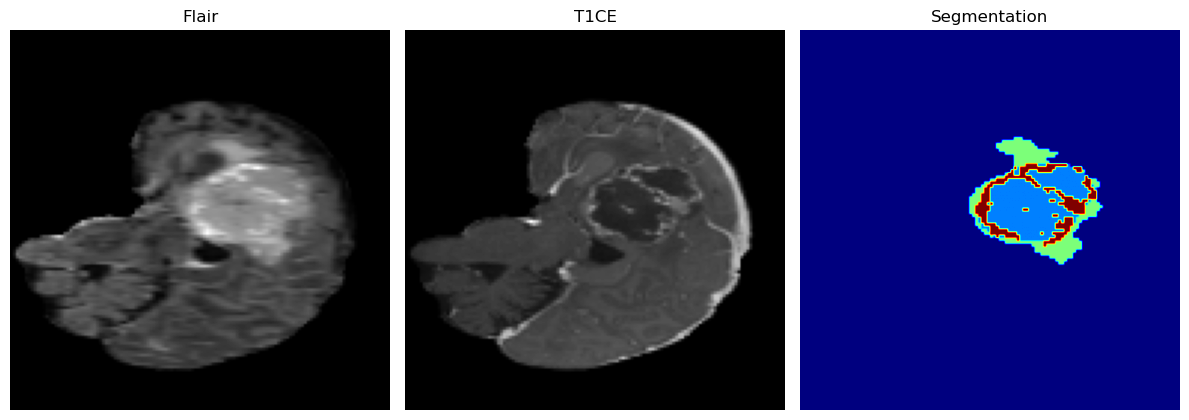

In [24]:
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Function to resize 3D medical images
def resize_3d(image, target_shape=(128, 128, 128), interp_order=1):
    zoom_factors = [t / s for s, t in zip(image.shape, target_shape)]
    return zoom(image, zoom_factors, order=interp_order)

# Function to display a 2D slice from 3D MRI volumes
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='jet')  # Use 'jet' colormap for segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Data generation function
def data_generation(data_path, Batch_ids, batch_size=1):
    X = np.empty((batch_size, 128, 128, 128, 2))  # Two channels: Flair & T1CE
    y = np.empty((batch_size, 128, 128, 128))  # Segmentation labels

    for c, case_id in enumerate(Batch_ids):
        case_path = os.path.join(data_path, case_id)

        # Load 3D MRI volumes
        flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
        t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
        seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

        # Resize using helper function
        X[c, :, :, :, 0] = resize_3d(flair, interp_order=1)  # Linear interpolation for MRI
        X[c, :, :, :, 1] = resize_3d(t1ce, interp_order=1)  # Linear interpolation for MRI
        y[c] = resize_3d(seg, interp_order=0)  # Nearest-neighbor for segmentation

    return X, y

# Define dataset path and example batch
data_path = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
Batch_ids = ["BraTS20_Training_120"]  # Replace with actual case IDs

# Generate batch
X_batch, Y_batch = data_generation(data_path, Batch_ids)

# Extract the first sample in the batch
flair_volume = X_batch[0, :, :, :, 0]   # Shape: (Depth, Height, Width)
t1ce_volume = X_batch[0, :, :, :, 1]    # Shape: (Depth, Height, Width)
segmentation_volume = Y_batch[0]  # Shape: (Depth, Height, Width)

# Select a middle slice
slice_index = segmentation_volume.shape[0] // 2
slice_flair = flair_volume[slice_index, :, :]
slice_t1ce = t1ce_volume[slice_index, :, :]
slice_segmentation = segmentation_volume[slice_index, :, :]

# Display the selected slice
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


**Loss Function**

When training a Convolutional Neural Network (CNN) for tasks like image segmentation, the loss function is used to measure how well the model's predictions match the actual (ground truth) data. The model uses this loss to improve itself during training by adjusting its weights to make more accurate predictions.
For tasks like segmenting brain tumors in images, there are two commonly used loss functions:

- Categorical Cross-Entropy:
This is typically used for multi-class problems. It compares the predicted probability for each pixel in the image to the actual (ground truth) label, which is often in the form of a one-hot encoded format (where each pixel belongs to a class like "brain tumor" or "healthy").
The goal is to minimize the difference between the predicted probabilities and the actual labels.

- Dice Loss:
This focuses on how well the predicted segmentation overlaps with the actual ground truth segmentation. It is especially useful for tasks like segmentation because it measures how much the model's predicted segment matches the true segment (e.g., the region of the brain with a tumor).
The model aims to maximize the overlap between the predicted and actual regions, improving the segmentation accuracy.

In [25]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    """
    Multi-class Dice Coefficient for 3D segmentation.

    Args:
        y_true: Ground truth labels, one-hot encoded.
        y_pred: Predicted labels, one-hot encoded (after softmax).

    Returns:
        Dice Coefficient averaged over all classes.
    """
    # Flatten all dimensions except for the class axis
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Calculate Dice Coefficient
    dice = (2. * intersection + K.epsilon()) / (union + K.epsilon())
    
    return dice


**Per Class Dice Coefficient Functions**
These functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

-  dice_coef_necrotic: Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.

-  dice_coef_edema: Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.

-  dice_coef_enhancing: Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [26]:
import tensorflow.keras.backend as K

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, :, 1] * y_pred[:, :, :, :, 1]))  # 3D volume
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, :, 2] * y_pred[:, :, :, :, 2]))  # 3D volume
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, :, 3] * y_pred[:, :, :, :, 3]))  # 3D volume
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, :, 3])) + epsilon)


**Evaluation Metrics**
To effectively monitor the model's performance, we use various evaluation metrics:

- Accuracy: Measures the overall proportion of correctly classified pixels. However, it can be misleading with imbalanced datasets like BraTS2020, where the background class is overrepresented.
- Intersection over Union (IoU): Measures the overlap between the predicted and ground truth segmentations.
- Dice Coefficient: Evaluates the similarity between predicted and ground truth segmentations.
- Sensitivity (Recall or True Positive Rate): Measures the proportion of positive ground truth pixels correctly predicted as positive.
- Precision (Positive Predictive Value): Measures the proportion of predicted positive pixels that are actually positive.
- Specificity (True Negative Rate): Measures the proportion of negative ground truth pixels correctly predicted as negative

In [27]:
import tensorflow.keras.backend as K

# 3D Precision Calculation
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # TP across depth, height, width
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))  # All predicted positives
    return true_positives / (predicted_positives + K.epsilon())

# 3D Sensitivity (Recall) Calculation
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # TP across depth, height, width
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))  # All actual positives
    return true_positives / (possible_positives + K.epsilon())

# 3D Specificity Calculation
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))  # TN across depth, height, width
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))  # All actual negatives
    return true_negatives / (possible_negatives + K.epsilon())


**Define the Segmentation Model**

**U-Net**

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans.

**3D U-Net :** More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.

**CHANGES REQUIRED FROM HERE**

In [28]:
def build_unet_3d(inputs, dropout=0.2):  # Changed input_shape to inputs (an Input tensor)
    kernel_init = tf.keras.initializers.HeNormal()

    # Encoder
    conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(inputs)
    conv1 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(pool1)
    conv2 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(pool2)
    conv3 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(pool3)
    conv4 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(pool4)
    conv5 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up6 = UpSampling3D(size=(2, 2, 2))(drop5)
    up6 = Conv3D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_init)(up6)
    merge6 = concatenate([conv4, up6], axis=4)
    conv6 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(merge6)
    conv6 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv6)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    up7 = Conv3D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_init)(up7)
    merge7 = concatenate([conv3, up7], axis=4)
    conv7 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(merge7)
    conv7 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv7)

    up8 = UpSampling3D(size=(2, 2, 2))(conv7)
    up8 = Conv3D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_init)(up8)
    merge8 = concatenate([conv2, up8], axis=4)
    conv8 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(merge8)
    conv8 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv8)

    up9 = UpSampling3D(size=(2, 2, 2))(conv8)
    up9 = Conv3D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_init)(up9)
    merge9 = concatenate([conv1, up9], axis=4)
    conv9 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(merge9)
    conv9 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_init)(conv9)

    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import tensorflow.keras.backend as K

# Enable mixed precision for faster training
mixed_precision.set_global_policy('float32')

# Define the input layer for 3D data (with 2 channels/modalities)
IMG_SIZE = 128  # Adjust this based on your dataset
NUM_CLASSES = 4  # Number of output classes

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, 2))  # 3D input with 2 channels

# Build the 3D U-Net model (assuming the function is defined)
model = build_unet_3d(input_layer, dropout=0.2)

# Dice coefficient for multi-class 3D segmentation
def dice_coef(y_true, y_pred, smooth=1.0):
    # Ensure y_true and y_pred are the same dtype
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to match y_pred's dtype
    
    class_num = 4  # Change if you have a different number of classes
    total_loss = 0  # Initialize total loss
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, :, i])  # Flatten entire 3D volume per class
        y_pred_f = K.flatten(y_pred[:, :, :, :, i])  # Flatten predicted 3D volume

        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        total_loss += dice  # Accumulate loss

    return total_loss / class_num  # Average over all classes

# Dice loss function for optimization
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Compile the model with an appropriate optimizer and loss function
model.compile(
    loss="categorical_crossentropy",  # Or use dice_loss if needed
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES),
        dice_coef
    ]
)

# Model summary to verify structure
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 128, 2)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 128, 128, 128, 32) │           1,760 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 128, 128, 128, 32) │          27,680 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 64, 64, 64, 32)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 64, 64, 64, 64)    │          55,360 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 64, 64, 64, 64)    │         110,656 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 32, 32, 32, 64)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 32, 32, 32, 128)   │         221,312 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 32, 32, 32, 128)   │         442,496 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 16, 16, 16, 128)   │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 16, 16, 16, 256)   │         884,992 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 16, 16, 16, 256)   │       1,769,728 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_3               │ (None, 8, 8, 8, 256)      │               0 │ conv3d_7[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_8 (Conv3D)             │ (None, 8, 8, 8, 512)      │       3,539,456 │ max_pooling3d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_9 (Conv3D)             │ (None, 8, 8, 8, 512)      │       7,078,400 │ conv3d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 8, 8, 8, 512)      │               

 Total params: 22,576,292 (86.12 MB)

 Trainable params: 22,576,292 (86.12 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=2, 
        min_lr=1e-6,  
        verbose=1
    ),
    ModelCheckpoint(
        filepath='checkpoints/model_epoch_{epoch:02d}_valLoss_{val_loss:.6f}.weights.h5',  # ✅ Fixed Extension
        monitor='val_loss',  
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True  # ✅ Ensures only weights are saved
    ),
    CSVLogger('logs/training_log.csv', separator=',', append=True)  
]


In [31]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Define input layer and model architecture (must be same as used during training)
input_layer = Input(shape=(128, 128, 128, 2))  # Adjust based on your input shape
model = build_unet_3d(input_layer, dropout=0.2)

# Compile the model with the same settings
model.compile(
    loss="categorical_crossentropy",  
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [32]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('complete_model.h5', custom_objects={'dice_coef': dice_coef})

# Display the model's architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 128, 2)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 128, 128, 128, 32) │           1,760 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 128, 128, 128, 32) │          27,680 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 64, 64, 64, 32)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 64, 64, 64, 64)    │          55,360 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 64, 64, 64, 64)    │         110,656 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 32, 32, 32, 64)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 32, 32, 32, 128)   │         221,312 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 32, 32, 32, 128)   │         442,496 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 16, 16, 16, 128)   │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 16, 16, 16, 256)   │         884,992 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 16, 16, 16, 256)   │       1,769,728 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_3               │ (None, 8, 8, 8, 256)      │               0 │ conv3d_7[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_8 (Conv3D)             │ (None, 8, 8, 8, 512)      │       3,539,456 │ max_pooling3d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_9 (Conv3D)             │ (None, 8, 8, 8, 512)      │       7,078,400 │ conv3d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 8, 8, 8, 512)      │               

 Total params: 22,576,294 (86.12 MB)

 Trainable params: 22,576,292 (86.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore weights from best epoch
)

# Checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',    # Save the best model
    monitor='val_loss',
    save_best_only=True
)


In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss=CategoricalCrossentropy(), 
    metrics=['accuracy', dice_coef]
)

# Retrain model with batch size 4
history = model.fit(
    training_generator,
    epochs=10,
    batch_size=4,  # Set batch size here
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


D:\Programs\anaconda1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3369s 13s/step - accuracy: 0.9896 - dice_coef: 0.2820 - loss: 0.0451
Epoch 2/10


D:\Programs\anaconda1\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,dice_coef,loss
  current = self.get_monitor_value(logs)
D:\Programs\anaconda1\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3350s 13s/step - accuracy: 0.9897 - dice_coef: 0.2853 - loss: 0.0427
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3349s 13s/step - accuracy: 0.9899 - dice_coef: 0.3032 - loss: 0.0410
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3357s 13s/step - accuracy: 0.9896 - dice_coef: 0.3257 - loss: 0.0366
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3352s 13s/step - accuracy: 0.9903 - dice_coef: 0.3304 - loss: 0.0348
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3357s 13s/step - accuracy: 0.9911 - dice_coef: 0.3542 - loss: 0.0295
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3478s 14s/step - accuracy: 0.9915 - dice_coef: 0.4003 - loss: 0.0260
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3609s 14s/step - accuracy: 0.9913 - dice_coef: 0.4083 - loss: 0.0247
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3638s 15s/step - accuracy: 0.9918 - dice_coef: 0.4298 - loss: 0.0231
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3640s 15s/step - accuracy: 0.9917 - dice_coef: 0.4380 - loss: 0.0219


In [58]:
IMG_SIZE = 128  # Same as used in training
VOLUME_SLICES = 128  # Number of slices used in training
VOLUME_START_AT = 22  # Adjust based on your data preprocessing

def load_and_preprocess(case_path, case):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Load FLAIR and T1CE MRI modalities
    flair_path = os.path.join(case_path, f'BraTS20_Validation_{case}/BraTS20_Validation_{case}_flair.nii')
    t1ce_path = os.path.join(case_path, f'BraTS20_Validation_{case}/BraTS20_Validation_{case}_t1ce.nii')

    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(t1ce_path).get_fdata()

    # Resize and stack the modalities
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the data
    X = X / np.max(X)

    return X

# Example usage:
case_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
case_id = '055'  # Replace with the actual case ID
X = load_and_preprocess(case_path, case_id)

In [59]:
# Predict on the input volume
predictions = model.predict(np.expand_dims(X, axis=0), verbose=1)

# Remove batch dimension
predictions = np.squeeze(predictions, axis=0)

# Apply argmax to get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 1800x5000 with 0 Axes>

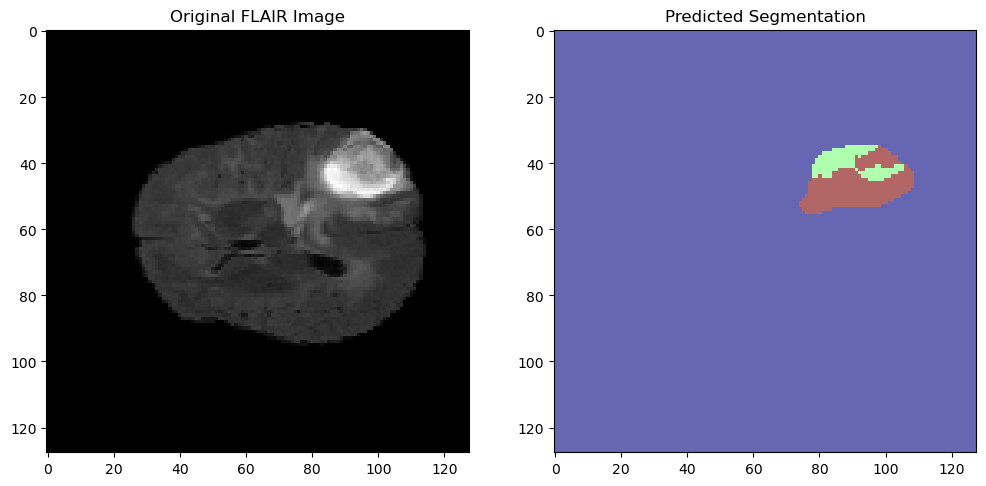

In [60]:
import matplotlib.pyplot as plt

def show_predictions(X, predicted_classes, start_slice=60):
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 2, figsize=(12, 6))

    # Show original FLAIR image
    axarr[0].imshow(X[start_slice, :, :, 0], cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')

    # Show predicted segmentation
    axarr[1].imshow(predicted_classes[start_slice, :, :], cmap="jet", alpha=0.6)
    axarr[1].title.set_text('Predicted Segmentation')

    plt.show()

# Display predictions for a slice
show_predictions(X, predicted_classes)


In [61]:
from sklearn.metrics import accuracy_score


In [63]:
true_flat = X.flatten()
pred_flat = predicted_classes.flatten()


In [66]:
print("True Classes Shape:", X.shape)
print("Predicted Classes Shape:", predicted_classes.shape)


True Classes Shape: (128, 128, 128, 2)
Predicted Classes Shape: (128, 128, 128)


In [69]:
# Convert one-hot encoded true labels to class labels
true_converted = np.argmax(X, axis=-1)

# Flatten both arrays
true_flat = true_converted.flatten()
pred_flat = predicted_classes.flatten()

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_flat, pred_flat)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.22%
